Session data saved to workout_data.csv
Angles data saved to angles_data.csv


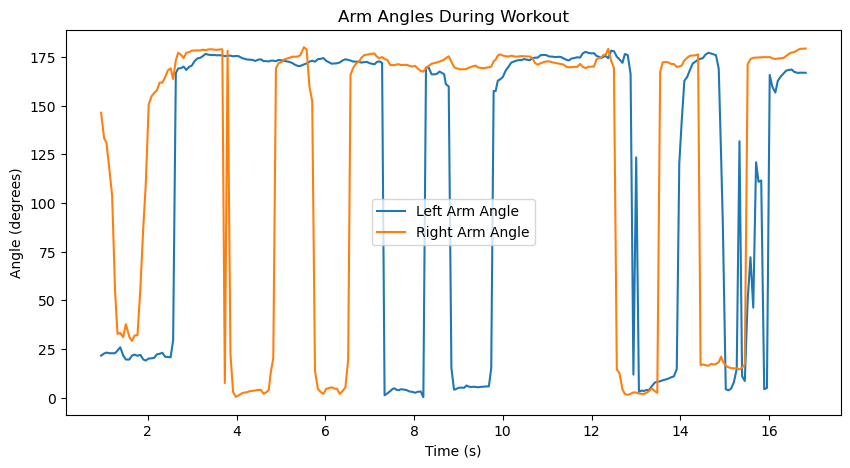

In [3]:
# Install necessary packages
!pip install opencv-python mediapipe pandas matplotlib

import cv2
import mediapipe as mp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

# Initialize mediapipe pose class
mp_drawing = mp.solutions.drawing_utils
mp_pose = mp.solutions.pose

# Function to calculate angle
def calculate_angle(a, b, c):
    a = np.array(a)  # First
    b = np.array(b)  # Mid
    c = np.array(c)  # End
    
    radians = np.arctan2(c[1] - b[1], c[0] - b[0]) - np.arctan2(a[1] - b[1], a[0] - b[0])
    angle = np.abs(radians * 180.0 / np.pi)
    
    if angle > 180.0:
        angle = 360 - angle
        
    return angle

# Function to save workout session data
def save_session_data(left_counter, right_counter, angles):
    data = {
        "Left Arm Curls": [left_counter],
        "Right Arm Curls": [right_counter]
    }
    df = pd.DataFrame(data)
    df.to_csv("workout_data.csv", index=False)
    print("Session data saved to workout_data.csv")

    # Save angles for visualization
    angles_df = pd.DataFrame(angles)
    angles_df.to_csv("angles_data.csv", index=False)
    print("Angles data saved to angles_data.csv")

# Function to plot angles
def plot_angles(angles):
    plt.figure(figsize=(10, 5))
    plt.plot(angles['time'], angles['left_arm'], label='Left Arm Angle')
    plt.plot(angles['time'], angles['right_arm'], label='Right Arm Angle')
    plt.xlabel('Time (s)')
    plt.ylabel('Angle (degrees)')
    plt.title('Arm Angles During Workout')
    plt.legend()
    plt.show()

# Main function for capturing video and processing pose
def start_workout():
    cap = cv2.VideoCapture(0)
    left_counter = 0
    right_counter = 0
    left_stage = ""
    right_stage = ""
    angles = {'time': [], 'left_arm': [], 'right_arm': []}
    start_time = time.time()

    with mp_pose.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.5) as pose:
        while cap.isOpened():
            ret, frame = cap.read()
            
            # Recolor image to RGB
            image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            image.flags.writeable = False
            
            # Make detection
            results = pose.process(image)
            
            # Recolor back to BGR
            image.flags.writeable = True
            image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
            
            # Extract landmarks
            try:
                landmarks = results.pose_landmarks.landmark
                
                # Get coordinates
                shoulder_1 = [landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER.value].x, landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER.value].y]
                elbow_1 = [landmarks[mp_pose.PoseLandmark.LEFT_ELBOW.value].x, landmarks[mp_pose.PoseLandmark.LEFT_ELBOW.value].y]
                wrist_1 = [landmarks[mp_pose.PoseLandmark.LEFT_WRIST.value].x, landmarks[mp_pose.PoseLandmark.LEFT_WRIST.value].y]
                
                shoulder_2 = [landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER.value].x, landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER.value].y]
                elbow_2 = [landmarks[mp_pose.PoseLandmark.RIGHT_ELBOW.value].x, landmarks[mp_pose.PoseLandmark.RIGHT_ELBOW.value].y]
                wrist_2 = [landmarks[mp_pose.PoseLandmark.RIGHT_WRIST.value].x, landmarks[mp_pose.PoseLandmark.RIGHT_WRIST.value].y]
                
                # Calculate angle
                angle_1 = calculate_angle(shoulder_1, elbow_1, wrist_1)
                angle_2 = calculate_angle(shoulder_2, elbow_2, wrist_2)
                
                # Visualize angle
                cv2.putText(image, str(angle_1),
                            tuple(np.multiply(elbow_1, [640, 480]).astype(int)),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2, cv2.LINE_AA
                            )
                cv2.putText(image, str(angle_2),
                            tuple(np.multiply(elbow_2, [640, 500]).astype(int)),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2, cv2.LINE_AA
                            )

                # Record angles
                elapsed_time = time.time() - start_time
                angles['time'].append(elapsed_time)
                angles['left_arm'].append(angle_1)
                angles['right_arm'].append(angle_2)

                # Curl counter logic for the left arm
                if angle_1 > 160:
                    left_stage = "down"
                if angle_1 < 30 and left_stage == "down":
                    left_stage = "up"
                    left_counter += 1
                if angle_1 > 175 or angle_1 < 5:
                    cv2.putText(image, "Left Arm Curl Incorrect", (10, 360), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)

                # Curl counter logic for the right arm
                if angle_2 > 160:
                    right_stage = "down"
                if angle_2 < 30 and right_stage == "down":
                    right_stage = "up"
                    right_counter += 1
                if angle_2 > 175 or angle_2 < 5:
                    cv2.putText(image, "Right Arm Curl Incorrect", (400, 360), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)

            except:
                pass

            # Render curl counter
            # Setup status box
            cv2.rectangle(image, (0, 0), (225, 73), (245, 117, 16), -1)

            # Rep data
            cv2.putText(image, 'Left Arm', (10, 100), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1, cv2.LINE_AA)
            cv2.putText(image, 'Curls: ' + str(left_counter), (10, 140), cv2.FONT_HERSHEY_SIMPLEX, 2, (255, 255, 255), 2, cv2.LINE_AA)
            cv2.putText(image, 'Stage: ' + left_stage, (10, 180), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 1, cv2.LINE_AA)

            cv2.putText(image, 'Right Arm', (400, 100), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1, cv2.LINE_AA)
            cv2.putText(image, 'Curls: ' + str(right_counter), (400, 140), cv2.FONT_HERSHEY_SIMPLEX, 2, (255, 255, 255), 2, cv2.LINE_AA)
            cv2.putText(image, 'Stage: ' + right_stage, (400, 180), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 1, cv2.LINE_AA)

            # Render detections
            mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_pose.POSE_CONNECTIONS,
                                      mp_drawing.DrawingSpec(color=(245, 117, 66), thickness=2, circle_radius=2),
                                      mp_drawing.DrawingSpec(color=(245, 66, 230), thickness=2, circle_radius=2)
                                      )

            cv2.imshow('Mediapipe Feed', image)

            if cv2.waitKey(10) & 0xFF == ord('q'):
                break

        cap.release()
        cv2.destroyAllWindows()
        save_session_data(left_counter, right_counter, angles)
        plot_angles(angles)

# Start the workout
start_workout()
